In [2]:
%%capture
!pip install gcsfs

In [3]:
import math

import gcsfs
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import IterableDataset, DataLoader, ChainDataset
from tqdm import tqdm, trange

### Read the dataset

In [4]:
# DATA_PATH = "/kaggle/input/riiid-test-answer-prediction/"
DATA_PATH = "gs://kds-e80dfc3d272252bbf34c627d756f891826dab0c19f30ec0fc3ac1979"

In [5]:
dtypes_train = {
    'row_id': 'int64',
    'timestamp': 'int64',
    'user_id': 'int32',
    'content_id': 'int16',
    'content_type_id': 'int8',
    'task_container_id': 'int16',
    'user_answer': 'int8',
    'answered_correctly': 'int8',
    'prior_question_elapsed_time': 'float32',
    'prior_question_had_explanation': 'boolean'
    }

dtypes_questions = {
    "question_id": "",
    "bundle_id": "",
    "correct_answer": "",
    "part": "",
    "tags": "",
}

dtypes_lectures = {
    "lecture_id": "",
    "part": "",
    "tag": "",
    "type_of": "",
}

In [6]:
train_df = pd.read_csv(DATA_PATH + "/train.csv", dtype=dtypes_train, nrows=1e6)
train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


In [7]:
questions_df = pd.read_csv(DATA_PATH + "/questions.csv")
questions_df.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [8]:
lectures_df = pd.read_csv(DATA_PATH + "/lectures.csv")
lectures_df.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [9]:
# removing lecture rows.
train_df = train_df[train_df.answered_correctly != -1]

In [10]:
train_df = train_df.join(questions_df, on="content_id")
train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,correct_answer,part,tags
0,0,0,115,5692,0,1,3,1,NaN,<NA>,5692,5692,3,5,151
1,1,56943,115,5716,0,2,2,1,37000.0,False,5716,5716,2,5,168
2,2,118363,115,128,0,0,0,1,55000.0,False,128,128,0,1,131 149 92
3,3,131167,115,7860,0,3,0,1,19000.0,False,7860,7860,0,1,131 104 81
4,4,137965,115,7922,0,4,1,1,11000.0,False,7922,7922,1,1,131 149 92


In [11]:
drop_cols = [
             "row_id", 
             "timestamp", 
             "content_type_id", 
             "user_answer", 
             "prior_question_had_explanation", 
             "question_id", 
             "bundle_id", 
             "correct_answer", 
             "tags"
             ]
train_df = train_df.drop(drop_cols, axis=1)
train_df.head()

,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,part
0,115,5692,1,1,NaN,5
1,115,5716,2,1,37000.0,5
2,115,128,0,1,55000.0,1
3,115,7860,3,1,19000.0,1
4,115,7922,4,1,11000.0,1


In [12]:
# 0 is used for padding, so increment 1
indicator_cols = ["content_id", "task_container_id", "part"]
for c in indicator_cols:
  train_df[c] = train_df[c] + 1
train_df.head()

,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,part
0,115,5693,2,1,NaN,6
1,115,5717,3,1,37000.0,6
2,115,129,1,1,55000.0,2
3,115,7861,4,1,19000.0,2
4,115,7923,5,1,11000.0,2


In [13]:
# convert milliseconds to minutes.
train_df['prior_question_elapsed_time'] = train_df["prior_question_elapsed_time"].fillna(0).astype(np.float32) / 60000
train_df.head()

,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,part
0,115,5693,2,1,0.000000,6
1,115,5717,3,1,0.616667,6
2,115,129,1,1,0.916667,2
3,115,7861,4,1,0.316667,2
4,115,7923,5,1,0.183333,2


In [14]:
user_groups = train_df.groupby("user_id")
user_groups_dict = {uid: udf for uid, udf in user_groups}
len(user_groups_dict)

3824

In [15]:
# sort based on the # of interactions for a user
sorted_user_groups = user_groups.count().sort_values("content_id")
sorted_user_groups.head()

,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,part
user_id,,,,,
19887248,1,1,1,1,1
1880240,1,1,1,1,1
15960740,2,2,2,2,2
2148001,2,2,2,2,2
1946295,3,3,3,3,3


In [16]:
sorted_uids = sorted_user_groups.index
sorted_uids

Int64Index([19887248,  1880240, 15960740,  2148001,  1946295, 11050314,
            12908124, 18249255, 15786147,  4280793,
            ...
            19489973,    24418, 15441391, 11610328,  3838215,  4421282,
             9418512, 18122922,  1283420,  7171715],
           dtype='int64', name='user_id', length=3824)

### Pytorch Iterable Dataset

In [17]:
# just some stuff I ctrl C ctrl V from StackOverflow (with little changes)
# [1,2,3,4] --- w = 2 --[[1,2], [2,3], [3,4]] but 2D to 3D
def rolling_window(a, w):
    s0, s1 = a.strides
    m, n = a.shape
    return np.lib.stride_tricks.as_strided(
        a, 
        shape=(m-w+1, w, n), 
        strides=(s0, s0, s1)
    )

def make_timeseries(x, window_length):
  """
  x - shape (seq_len, features)
  """
  # pad a lot of 0s before so when we create windows, we will have appropriate padding.
  x = np.pad(x, ((window_length-1, 0), (0, 0)), constant_values=0) # add padding to the first dimension
  
  # roll windows 
  x = rolling_window(x, window_length) # shape will become - (seq_len, window_length, features)

  return x

def add_features_to_user_df(user_df):

  # shifted answered_correctly, SOS 3
  user_df["answered_correctly"] = user_df["answered_correctly"].shift(fill_value=2) + 1

  return user_df

#### Sequence to Sequence Dataset

In [18]:
class RiidS2SDataset(IterableDataset):
  def __init__(self, user_groups_dict, uids, seq_len=128, batch_size=32, n_batches=None):
    super().__init__()
    self.user_groups_dict = user_groups_dict
    self.uids = uids
    self.batch_size = batch_size
    self.seq_len = seq_len
    self.__len = None
    self.n_batches = n_batches
    if n_batches:
      self.__len = n_batches

  def __len__(self):
    if not self.__len:
      b = 0
      for xb, yb in self:
        b += 1
      self.__len = b
    return self.__len

  def create_batch(self, xs, ys):
    padded_xs, padded_ys = [], []
    maxlen = max(len(x) for x in xs)
    for i in range(len(xs)):
      padded_xs.append(np.pad(xs[i], ((maxlen-len(xs[i]), 0), (0, 0)), constant_values=0))
      padded_ys.append(np.pad(ys[i], (maxlen-len(ys[i]), 0), constant_values=0))
    return padded_xs, padded_ys

  def __iter__(self):
    b = 0
    xs, ys = [], []
    for user_id in self.uids:
      user_df = self.user_groups_dict[user_id].drop(columns="user_id")
      y = user_df["answered_correctly"].to_numpy().copy()
      x = add_features_to_user_df(user_df).values
      if y.shape[0] < self.seq_len:
        xs.append(x)
        ys.append(y)
        b += 1
        if b == self.batch_size:
            padded_xs, padded_ys = self.create_batch(xs, ys)
            yield np.transpose(np.stack(padded_xs), (1, 0, 2)), np.stack(padded_ys) # reshape x to [seq_len, bs, n_features]
            b = 0
            xs, ys = [], []
      else:
        for i in range(0, y.shape[0], self.seq_len):
          start, end = i, i + self.seq_len
          if end > y.shape[0]:
            xs.append(x[start:])
            ys.append(y[start:])
          else:
            xs.append(x[start:end])
            ys.append(y[start:end])
          b += 1
          if b == self.batch_size:
            padded_xs, padded_ys = self.create_batch(xs, ys)
            yield np.transpose(np.stack(padded_xs), (1, 0, 2)), np.stack(padded_ys) # reshape x to [seq_len, bs, n_features]
            b = 0
            xs, ys = [], []

In [19]:
riid_ds = RiidS2SDataset(user_groups_dict, sorted_uids, seq_len=128, batch_size=4)

In [20]:
riid_ds_iter = iter(riid_ds)
xb, yb = next(riid_ds_iter)
xb.shape, yb.shape

((2, 4, 5), (4, 2))

Check the first sample in the batch

In [21]:
xb[:, 0, :]

array([[0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [6.369e+03, 1.000e+00, 3.000e+00, 0.000e+00, 6.000e+00]])

In [22]:
yb[0, :]

array([0, 0], dtype=int8)

In [23]:
sorted_uids[0]

19887248

In [24]:
train_df[train_df["user_id"] == 19887248]

,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,part
965193,19887248,6369,1,0,0.0,6


Check the last sample in the batch

In [25]:
xb[:, -1, :]

array([[5.21400000e+03, 1.00000000e+00, 3.00000000e+00, 0.00000000e+00,
        6.00000000e+00],
       [9.32100000e+03, 2.00000000e+00, 2.00000000e+00, 3.49999994e-01,
        6.00000000e+00]])

In [26]:
yb[-1, :]

array([1, 0], dtype=int8)

In [27]:
sorted_uids[3] # batch size - 4

2148001

In [28]:
train_df[train_df["user_id"] == 2148001]

,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,part
103083,2148001,5214,1,1,0.00,6
103084,2148001,9321,2,0,0.35,6


#### Dataloader

In [29]:
train_dl = DataLoader(riid_ds, batch_size=None)
x, y = next(iter(train_dl))
x.shape, y.shape, x.dtype, y.dtype

(torch.Size([2, 4, 5]), torch.Size([4, 2]), torch.float64, torch.int8)

In [30]:
len(train_dl)

2530

In [31]:
batches = 0
max_batch_size = 0
max_seq_len = 0
for xb, yb in train_dl:
    max_batch_size = max(max_batch_size, xb.size(1))
    max_seq_len = max(max_seq_len, xb.size(0))
    batches += 1
    
max_batch_size, max_seq_len, batches

(4, 128, 2530)

##### Padding mask

In [33]:
pad_mask = torch.all(torch.eq(x, 0), dim=-1).T
pad_mask

tensor([[ True, False],
        [ True, False],
        [False, False],
        [False, False]])

Look ahead mask

In [34]:
  def generate_square_subsequent_mask(sz):
        r"""Generate a square mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
        """
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, True).masked_fill(mask == 1, False)
        return mask.bool()

In [35]:
look_ahead_mask = generate_square_subsequent_mask(x.size(0))
look_ahead_mask

tensor([[False,  True],
        [False, False]])

#### Combining Padding mask and Lookahead mask

Combining look ahead mask and padding mask is difficult.

Imagine you have a sequence

In [174]:
a = [0, 0, 2, 3]

The first 4 fields are pad values. So if we use the `src_key_padding_mask` argument of pytorch attention. We are telling the attention module. for all the items in the sequence do not attend to the first 2 values.

In [175]:
x = torch.as_tensor(a).float()
x

tensor([0., 0., 2., 3.])

In [176]:
pad_mask = torch.tensor([[True, True, False, False]])
pad_mask.shape

torch.Size([1, 4])

In [177]:
attn = torch.nn.MultiheadAttention(embed_dim=1, num_heads=1)

In [178]:
x = x.T.unsqueeze(1).unsqueeze(1) # matching attention shape - [seq_len, bs, n_features]
x.shape

torch.Size([4, 1, 1])

In [179]:
output, score = attn(x, x, x, key_padding_mask=pad_mask) #, attn_mask=attn_mask)

In [180]:
score

tensor([[[0.0000, 0.0000, 0.5000, 0.5000],
         [0.0000, 0.0000, 0.5000, 0.5000],
         [0.0000, 0.0000, 0.8819, 0.1181],
         [0.0000, 0.0000, 0.9533, 0.0467]]], grad_fn=<DivBackward0>)

As expected it gives 0 weightage to the first 2 items in te sequence while creating the output vector.  

But still pay attention that first item in the sequence still get to attend to the last 2 values in the sequence.  

This cannot be permitted when look ahead limitation.  


So the natural thing to do is add a look ahead mask

In [181]:
look_ahead_mask = torch.as_tensor([[0., float('-inf'), float('-inf'), float('-inf')],
                             [0., 0., float('-inf'), float('-inf')],
                             [float('-inf'), 0., 0., float('-inf')],
                             [float('-inf'), float('-inf'), 0., 0.]])

In [182]:
output, score = attn(x, x, x, key_padding_mask=pad_mask, attn_mask=attn_mask)
score

tensor([[[   nan,    nan,    nan,    nan],
         [   nan,    nan,    nan,    nan],
         [0.0000, 0.0000, 1.0000, 0.0000],
         [0.0000, 0.0000, 0.9533, 0.0467]]], grad_fn=<DivBackward0>)

If we use both look ahead and attn mask. we are saying to the first item in the sequence.

* look ahead mask saying - DO NOT LOOK AHEAD TO THE REST OF SEQUENCE ONLY LOOK AT YOURSELF.
* Padding mask saying - YOU ARE PAD VALUE SO DONT LOOK AT YOUR SELF.

Resulting in all `-inf` values, and the softmax giving `nan`

SO THE BEST THING TO DO IS, USE ONLY LOOK AHEAD MASK, AND USE THE PAD_MASK IN THE LOSS FUNCTION TO MASK OUT LABELS RELATED TO THE PAD TOKENS

### Transformer Sequence Classifier.

Positional Encoding

In [36]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [37]:
class TransformerClassifier(nn.Module):
    
    def __init__(self, n_tokens_dict, d_model=512, n_heads=8, hidden_dim=1024, n_layers=1, dropout=0):
        
        super().__init__()
        self.d_model = d_model
        
        # Transformer encoder blocks
        encoder_layer = nn.TransformerEncoderLayer(d_model, n_heads, hidden_dim, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, n_layers)
        
        # Input embeddings for content_id, task_container_id, answered_correctly, prior_question_elapsed_time, part
        self.content_id_emb = nn.Embedding(n_tokens_dict["content_id"], d_model)
        self.task_container_id_emb = nn.Embedding(n_tokens_dict["task_container_id"], d_model)
        self.answered_correctly_emb = nn.Embedding(n_tokens_dict["answered_correctly"], d_model)
        self.part_emb = nn.Embedding(n_tokens_dict["part"], d_model)
        self.prior_question_elapsed_time_emb = nn.Linear(1, d_model, bias=False)
        # Positional Encoding
        self.pos_enc = PositionalEncoding(d_model=d_model, dropout=dropout)

        self.out = nn.Linear(d_model, 1)
        
    def forward(self, x):

        seq_len, bs, n_features = x.size()
        device = x.device

        # padding mask
        src_key_padding_mask = torch.all(torch.eq(x, 0), dim=-1).T # shape [bs, seq_len]
        print(f"padding mask : {src_key_padding_mask}")

        # look ahead mask
        look_ahead_mask = generate_square_subsequent_mask(seq_len).to(device)
        print(f"look ahead mask: {look_ahead_mask}")

        # input embedding
        content_id_emb = self.content_id_emb(x[..., 0].long())
        task_container_id_emb = self.task_container_id_emb(x[..., 1].long())
        answered_correctly_emb = self.answered_correctly_emb(x[..., 2].long())
        part_emb = self.part_emb(x[..., 4].long())
        # prior_question_elapsed_time_emb = self.prior_question_elapsed_time_emb(x[..., 3].unsqueeze(-1).float())
        
        # shape [seq_len, bs, d_model]
        input_emb = (content_id_emb 
                     + task_container_id_emb
                     + answered_correctly_emb
                     + part_emb
                     # + prior_question_elapsed_time_emb
                     )
        input_emb = input_emb * math.sqrt(self.d_model) # needed?

        input_emb = self.pos_enc(input_emb) # position encoding
        
        # transformer blocks
        z = self.transformer_encoder(input_emb, mask=look_ahead_mask, src_key_padding_mask=src_key_padding_mask) # shape [seq_len, bs, d_model]
        
        # output layer
        out = self.out(z) # shape [seq_len, bs, 1]
        
        return torch.sigmoid(out) # shape [seq_len, bs, 1]
        


In [38]:
n_tokens_dict = {
    "content_id": max(train_df["content_id"]) + 1,
    "task_container_id": max(train_df["task_container_id"]) + 1,
    "answered_correctly": 4, # 0-padding, 1-incorrect, 2-correct, 3-fill value
    "part": max(train_df["part"]) + 1
}

n_tokens_dict

{'answered_correctly': 4,
 'content_id': 13524,
 'part': 9,
 'task_container_id': 7741}

In [39]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [40]:
model = TransformerClassifier(n_tokens_dict).to(device)
model

TransformerClassifier(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=1024, bias=True)
        (dropout): Dropout(p=0, inplace=False)
        (linear2): Linear(in_features=1024, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0, inplace=False)
        (dropout2): Dropout(p=0, inplace=False)
      )
    )
  )
  (content_id_emb): Embedding(13524, 512)
  (task_container_id_emb): Embedding(7741, 512)
  (answered_correctly_emb): Embedding(4, 512)
  (part_emb): Embedding(9, 512)
  (prior_question_elapsed_time_emb): Linear(in_features=1, out_features=512, bias=False)
  (pos_enc): PositionalEncodi

In [41]:
xb = x.to(device)
print(f"Input : {xb.shape}")
preds = model(xb)
print(f"Output: {preds.shape}")

Input : torch.Size([2, 4, 5])
padding mask : tensor([[ True, False],
        [ True, False],
        [False, False],
        [False, False]])
look ahead mask: tensor([[False,  True],
        [False, False]])
Output: torch.Size([2, 4, 1])


In [231]:
preds[:, 0, :]

tensor([[   nan],
        [0.3995]], grad_fn=<SliceBackward>)

In [1]:
yb = y.T.float().to(device)
print(yb)
loss_func(preds, yb.unsqueeze(dim=-1))

NameError: ignored

### Training

In [135]:
epochs = 100
opt = torch.optim.Adam(params=model.parameters(), lr=0.001)
sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=0.001, steps_per_epoch=len(train_dl), epochs=epochs)
loss_func = nn.BCELoss()

https://pytorch.org/tutorials/beginner/nn_tutorial.html#create-fit-and-get-data

In [231]:
def loss_batch(model, loss_func, X_batch, y_batch, opt=None):

  preds = model(X_batch)
  loss = loss_func(preds, y_batch.unsqueeze(dim=-1))

  if opt is not None:
    loss.backward()
    # nn.utils.clip_grad_norm_(model.parameters(), 0.25)
    opt.step()
    opt.zero_grad()

  return loss.item(), X_batch.shape[2]

In [232]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl=None, sched=None):
  epoch_losses = []
  epoch_lrs = []
  for e in range(epochs):
    # train
    lrs = []
    train_losses = []
    val_losses = []

    model.train()
    train_dl = tqdm(train_dl, position=0, leave=True)
    for X_batch, y_batch in train_dl:
      X_batch, y_batch = X_batch.to(device), y_batch.T.type(torch.FloatTensor).to(device)
      train_loss, train_bs = loss_batch(model, loss_func, X_batch, y_batch, opt)
      train_losses.append(train_loss)
      train_loss_mean = sum(train_losses) / len(train_losses)
      lr = opt.param_groups[0]["lr"]
      lrs.append(lr)
      train_dl.set_description(f"Epoch: {e}, RunningLoss: {train_loss_mean:.3f}, InstantLoss: {train_loss:.3f}, LR: {lr:.6f}")
      if sched:
        sched.step()
    epoch_losses.append(train_loss_mean)
    epoch_lrs.append(lr)
    # eval
    # model.eval()
    # with torch.no_grad():
    #   val_losses, val_bss = zip(*[loss_batch(model, loss_func, X_batch, y_batch) for X_batch, y_batch in valid_dl])

    # val_loss = np.sum(np.multiply(val_losses, val_bss)) / np.sum(val_bss)
    # train_dl.set_description(f"Epoch: {e}, Loss: {train_loss}, Val Loss: {val_loss}")

  return epoch_losses, epoch_lrs#, val_losses

In [233]:
train_losses, lrs = fit(epochs, model, loss_func, opt, train_dl, sched=sched)

Epoch: 0, RunningLoss: 0.636, InstantLoss: 0.764, LR: 0.000043: 100%|██████████| 98/98 [00:07<00:00, 12.80it/s]
Epoch: 1, RunningLoss: 0.627, InstantLoss: 0.744, LR: 0.000050: 100%|██████████| 98/98 [00:07<00:00, 12.53it/s]
Epoch: 2, RunningLoss: 0.623, InstantLoss: 0.759, LR: 0.000063: 100%|██████████| 98/98 [00:07<00:00, 12.61it/s]
Epoch: 3, RunningLoss: 0.621, InstantLoss: 0.756, LR: 0.000081: 100%|██████████| 98/98 [00:07<00:00, 12.52it/s]
Epoch: 4, RunningLoss: 0.619, InstantLoss: 0.745, LR: 0.000104: 100%|██████████| 98/98 [00:07<00:00, 12.66it/s]
Epoch: 5, RunningLoss: 0.619, InstantLoss: 0.727, LR: 0.000131: 100%|██████████| 98/98 [00:07<00:00, 12.82it/s]
Epoch: 6, RunningLoss: 0.617, InstantLoss: 0.723, LR: 0.000163: 100%|██████████| 98/98 [00:07<00:00, 12.83it/s]
Epoch: 7, RunningLoss: 0.615, InstantLoss: 0.762, LR: 0.000199: 100%|██████████| 98/98 [00:07<00:00, 12.85it/s]
Epoch: 8, RunningLoss: 0.612, InstantLoss: 0.748, LR: 0.000238: 100%|██████████| 98/98 [00:07<00:00, 12.

In [234]:
import matplotlib.pyplot as plt

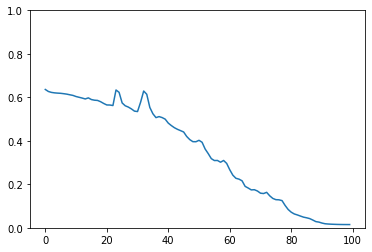

In [235]:
plt.ylim(top=1)
plt.plot(train_losses)

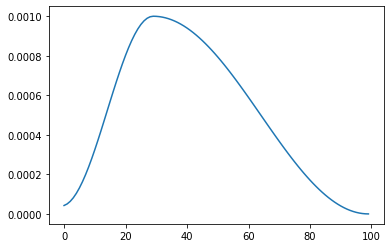

In [236]:
plt.plot(lrs)

In [237]:
xb = xb.to(device)
preds = model(xb)

In [238]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

In [239]:
y_hat = preds.to("cpu").detach().numpy() > 0.5
y_hat = y_hat.astype(np.int8).flatten()
y_hat.shape

(8192,)

In [240]:
y_true = yb.to("cpu").detach().numpy().T.flatten()
y_true.shape

(8192,)

In [241]:
accuracy_score(y_true, y_hat)

1.0

In [242]:
precision_score(y_true, y_hat)

1.0

In [243]:
recall_score(y_true, y_hat)

1.0

In [244]:
y_true.T

array([1, 1, 1, ..., 0, 0, 0], dtype=int8)

In [245]:
y_hat.T

array([1, 1, 1, ..., 0, 0, 0], dtype=int8)

In [246]:
roc_auc_score(y_true, preds.to("cpu").detach().numpy().flatten())

1.0